# Fetch Spotify Artist Info

This notebook fetches artist genres and popularity from the Spotify API.

> **Note**: The audio features endpoint (`/audio-features`) is blocked for new Spotify apps since November 2024. 
> We use artist genres and popularity instead, which is sufficient for controllable recommendations.

## Setup

1. Go to https://developer.spotify.com/dashboard
2. Create an app (any name, select "Web API")
3. Copy Client ID and Client Secret
4. Add to your `.env` file:

```
SPOTIFY_CLIENT_ID=your_client_id
SPOTIFY_CLIENT_SECRET=your_client_secret
```


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from tqdm import tqdm
import time
import os
from dotenv import load_dotenv
from collections import Counter
import matplotlib.pyplot as plt

load_dotenv()


True

In [2]:
client_id = os.getenv("SPOTIFY_CLIENT_ID")
client_secret = os.getenv("SPOTIFY_CLIENT_SECRET")

if not client_id or not client_secret:
    raise ValueError("Missing SPOTIFY_CLIENT_ID or SPOTIFY_CLIENT_SECRET in .env file")

sp = spotipy.Spotify(
    auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret),
    requests_timeout=10,
    retries=3
)

sp.search(q="test", limit=1)
print("Spotify API connected!")


Spotify API connected!


In [3]:
MODEL_DIR = Path("../models")
DATA_DIR = Path("../data/processed")
DATA_DIR.mkdir(parents=True, exist_ok=True)

track_df = pd.read_parquet(MODEL_DIR / "track_metadata.parquet")
print(f"Loaded {len(track_df):,} tracks")

def extract_id(uri):
    return uri.split(":")[-1]

track_df['track_id'] = track_df['track_uri'].apply(extract_id)
track_df['artist_id'] = track_df['artist_uri'].apply(extract_id)

track_ids = track_df['track_id'].unique().tolist()
artist_ids = track_df['artist_id'].unique().tolist()

print(f"Track IDs: {len(track_ids):,}")
print(f"Artist IDs: {len(artist_ids):,}")

# Calculate track popularity from playlist occurrences
import json

PLAYLIST_DATA_PATH = Path.home() / ".cache/kagglehub/datasets/himanshuwagh/spotify-million/versions/1/data"
slice_files = sorted(PLAYLIST_DATA_PATH.glob("mpd.slice.*.json"))

track_playlist_count = Counter()
for slice_file in slice_files:
    with open(slice_file) as f:
        data = json.load(f)
        for playlist in data["playlists"]:
            for track in playlist["tracks"]:
                track_playlist_count[track["track_uri"]] += 1

# Add playlist count to track_df
track_df['playlist_count'] = track_df['track_uri'].map(track_playlist_count).fillna(0).astype(int)
print(f"\nPlaylist counts: min={track_df['playlist_count'].min()}, max={track_df['playlist_count'].max()}, median={track_df['playlist_count'].median():.0f}")


Loaded 252,999 tracks
Track IDs: 252,999
Artist IDs: 49,124

Playlist counts: min=1, max=878, median=1


## API Diagnostics

Test which Spotify API endpoints we have access to. Audio features was deprecated for new apps in Nov 2024.


In [4]:
test_track_id = track_ids[0]
test_artist_id = artist_ids[0]

print("Testing Spotify API endpoints...")
print("=" * 50)

# Test 1: Track info
try:
    track = sp.track(test_track_id)
    print(f"Track endpoint:    OK - {track['name']}")
except Exception as e:
    print(f"Track endpoint:    FAILED - {type(e).__name__}")

# Test 2: Artist info
try:
    artist = sp.artist(test_artist_id)
    print(f"Artist endpoint:   OK - {artist['name']}, genres: {artist['genres'][:2]}")
except Exception as e:
    print(f"Artist endpoint:   FAILED - {type(e).__name__}")

# Test 3: Audio features (blocked for new apps since Nov 2024)
AUDIO_FEATURES_AVAILABLE = False
try:
    features = sp.audio_features([test_track_id])
    if features and features[0]:
        print(f"Audio features:    OK - danceability: {features[0]['danceability']}")
        AUDIO_FEATURES_AVAILABLE = True
    else:
        print("Audio features:    BLOCKED (returns None)")
except Exception as e:
    print(f"Audio features:    BLOCKED ({type(e).__name__})")

print("=" * 50)

if not AUDIO_FEATURES_AVAILABLE:
    print("\nAudio features endpoint is blocked for new apps (Nov 2024 change).")
    print("We'll use artist genres + popularity instead - this is enough for")
    print("controllable recommendations!")

Testing Spotify API endpoints...
Track endpoint:    OK - Lose Control (feat. Ciara & Fat Man Scoop)


HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0UaMYEvWZi0ZqiDOoHU3YI with Params: {} returned 403 due to None


Artist endpoint:   OK - Missy Elliott, genres: ['hip hop']
Audio features:    BLOCKED (SpotifyException)

Audio features endpoint is blocked for new apps (Nov 2024 change).
We'll use artist genres + popularity instead - this is enough for
controllable recommendations!


In [5]:
def fetch_artist_info(artist_ids, batch_size=50):
    """Fetch artist info (genres, popularity, followers) in batches."""
    all_artists = []
    
    for i in tqdm(range(0, len(artist_ids), batch_size), desc="Fetching artists"):
        batch = artist_ids[i:i + batch_size]
        try:
            artists = sp.artists(batch)['artists']
            for a in artists:
                if a:
                    all_artists.append({
                        'artist_id': a['id'],
                        'artist_name': a['name'],
                        'genres': a['genres'],
                        'artist_popularity': a['popularity'],
                        'artist_followers': a['followers']['total']
                    })
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(5)
        time.sleep(0.1)
    
    return all_artists


In [6]:
ARTIST_PATH = DATA_DIR / "artist_info.parquet"

if ARTIST_PATH.exists():
    print("Loading cached artist info...")
    artist_df = pd.read_parquet(ARTIST_PATH)
else:
    print(f"Fetching {len(artist_ids):,} artists (~{len(artist_ids)//50//6} min)...")
    artists = fetch_artist_info(artist_ids)
    artist_df = pd.DataFrame(artists)
    artist_df.to_parquet(ARTIST_PATH, index=False)

print(f"Artist info: {len(artist_df):,} artists")
print(f"Artists with genres: {(artist_df['genres'].str.len() > 0).sum():,}")
artist_df.head()


Loading cached artist info...
Artist info: 49,124 artists
Artists with genres: 27,990


,artist_id,artist_name,genres,artist_popularity,artist_followers
0,2wIVse2owClT7go1WT98tk,Missy Elliott,[hip hop],71,2796703
1,26dSoYclwsYLMAKD3tpOr4,Britney Spears,[pop],84,18275377
2,6vWDO969PvNqNYHIOW5v0m,Beyoncé,[],86,41787960
3,31TPClRtHm23RisEBtV3X7,Justin Timberlake,[],84,16166379
4,5EvFsr3kj42KNv97ZEnqij,Shaggy,[reggae],76,2561816


## Explore Genres

In [8]:
all_genres = []
for genres in artist_df['genres']:
    if len(genres) > 0:
        all_genres.extend(genres)

genre_counts = Counter(all_genres)
top_genres = genre_counts.most_common(30)

print(f"Total unique genres: {len(genre_counts):,}")
print("\nTop 30 genres:")
for genre, count in top_genres:
    print(f"  {count:5d} | {genre}")


Total unique genres: 753

Top 30 genres:
    585 | worship
    560 | reggae
    548 | jazz
    503 | musicals
    503 | christian
    429 | dubstep
    423 | trance
    415 | americana
    414 | gospel
    359 | post-hardcore
    351 | alt country
    337 | progressive trance
    335 | ccm
    327 | metalcore
    319 | bluegrass
    317 | country
    292 | cumbia
    287 | blues
    286 | hymns
    283 | doo-wop
    279 | roots reggae
    278 | pop punk
    278 | garage rock
    275 | metal
    274 | classical
    273 | christian alternative rock
    270 | swing music
    268 | salsa
    266 | nu disco
    262 | nu jazz


# Popularity distribution

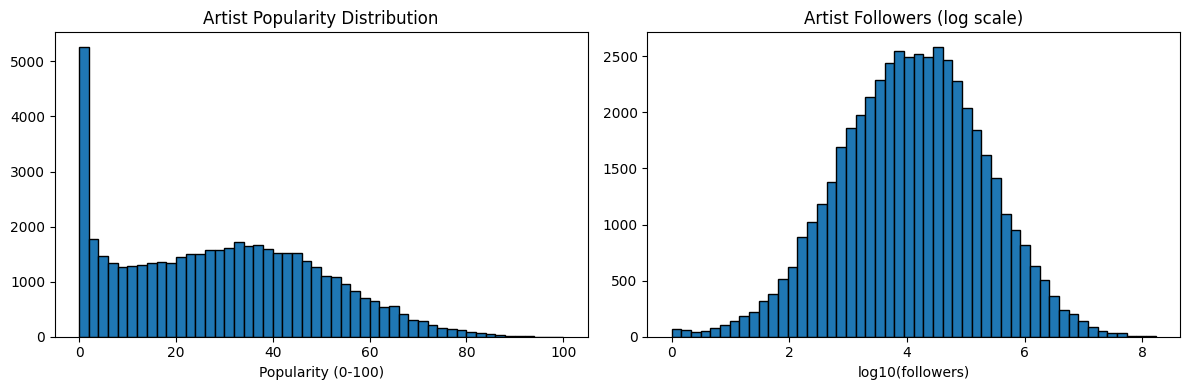

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(artist_df['artist_popularity'], bins=50, edgecolor='black')
axes[0].set_title('Artist Popularity Distribution')
axes[0].set_xlabel('Popularity (0-100)')

axes[1].hist(np.log10(artist_df['artist_followers'] + 1), bins=50, edgecolor='black')
axes[1].set_title('Artist Followers (log scale)')
axes[1].set_xlabel('log10(followers)')

plt.tight_layout()
plt.show()


## Create Enriched Dataset

Merge track metadata with artist info.


In [10]:
# Drop artist_name from artist_df to avoid duplicate columns
artist_df_slim = artist_df.drop(columns=['artist_name'])

enriched_tracks = track_df.merge(artist_df_slim, on='artist_id', how='left')

print(f"Enriched tracks: {len(enriched_tracks):,}")
print(f"\nCoverage:")
print(f"  Genres: {enriched_tracks['genres'].notna().sum():,} ({enriched_tracks['genres'].notna().mean()*100:.1f}%)")
print(f"  Artist popularity: {enriched_tracks['artist_popularity'].notna().sum():,} ({enriched_tracks['artist_popularity'].notna().mean()*100:.1f}%)")
print(f"  Playlist count: {(enriched_tracks['playlist_count'] > 0).sum():,} ({(enriched_tracks['playlist_count'] > 0).mean()*100:.1f}%)")

print(f"\nColumns: {enriched_tracks.columns.tolist()}")
enriched_tracks.head()


Enriched tracks: 257,667

Coverage:
  Genres: 256,089 (99.4%)
  Artist popularity: 256,089 (99.4%)
  Playlist count: 257,667 (100.0%)

Columns: ['track_uri', 'track_name', 'artist_name', 'album_name', 'artist_uri', 'album_uri', 'duration_ms', 'track_id', 'artist_id', 'playlist_count', 'genres', 'artist_popularity', 'artist_followers']


,track_uri,track_name,artist_name,album_name,artist_uri,album_uri,duration_ms,track_id,artist_id,playlist_count,genres,artist_popularity,artist_followers
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,The Cookbook,spotify:artist:2wIVse2owClT7go1WT98tk,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,0UaMYEvWZi0ZqiDOoHU3YI,2wIVse2owClT7go1WT98tk,116,[hip hop],71.0,2796703.0
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears,In The Zone,spotify:artist:26dSoYclwsYLMAKD3tpOr4,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,6I9VzXrHxO9rA9A5euc8Ak,26dSoYclwsYLMAKD3tpOr4,267,[pop],84.0,18275377.0
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé,Dangerously In Love (Alben für die Ewigkeit),spotify:artist:6vWDO969PvNqNYHIOW5v0m,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,0WqIKmW4BTrj3eJFmnCKMv,6vWDO969PvNqNYHIOW5v0m,355,[],86.0,41787960.0
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,Justified,spotify:artist:31TPClRtHm23RisEBtV3X7,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,1AWQoqb9bSvzTjaLralEkT,31TPClRtHm23RisEBtV3X7,164,[],84.0,16166379.0
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy,Hot Shot,spotify:artist:5EvFsr3kj42KNv97ZEnqij,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,1lzr43nnXAijIGYnCT8M8H,5EvFsr3kj42KNv97ZEnqij,462,[reggae],76.0,2561816.0


ENRICHED_PATH = DATA_DIR / "enriched_tracks.parquet"
enriched_tracks.to_parquet(ENRICHED_PATH, index=False)
print(f"Saved {len(enriched_tracks):,} enriched tracks to {ENRICHED_PATH}")


## Summary

We now have enriched track data with:
- **Artist genres** - for genre-based filtering
- **Artist popularity** (0-100) - for mainstream vs obscure artist recommendations
- **Artist followers** - another artist popularity metric
- **Playlist count** - track popularity (how many playlists the song appears in)

This is enough to build controllable recommendations in the next notebook!


---
**Notebook complete!** Run cells 1-14 in order, then proceed to the next notebook.
